# 3. Создание нейронной сети при помощи пакета `torch`. Dataset и Dataloader.

__Автор__: Никита Владимирович Блохин (NVBlokhin@fa.ru)

Финансовый университет, 2020 г. 

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

## 1. Автоматическое дифференцирование в `torch`

1.1 Воспользовавшись классами `Neuron` и `MSELoss` из задачи 2.4.1 и автоматическим дифференцированием, которое предоставляет `torch`, решить задачу регрессии. Для оптимизации использовать стохастический градиетный спуск.

In [2]:
from sklearn.datasets import make_regression

X, y, coef = make_regression(n_features=4, n_informative=4, coef=True, bias=0.5)
X = torch.from_numpy(X).to(dtype=torch.float32)
y = torch.from_numpy(y).to(dtype=torch.float32)

In [3]:
class MSE_Loss:

    def forward(self, y_pred: torch.Tensor, y_true: torch.Tensor):
        return (y_pred - y_true) ** 2

    def backward(self, y_pred: torch.Tensor, y_true: torch.Tensor):
        self.dinput = 2 * (y_pred - y_true)

In [4]:
class Neuron:
    def __init__(self, n_inputs: int):
        self.n_inputs = n_inputs
        
        self.weights = torch.randn(n_inputs, requires_grad=True)
        self.bias = torch.randn(1, requires_grad=True)
  
    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        self.inputs = inputs
        return torch.sum(self.weights * inputs) + self.bias

In [5]:
torch.manual_seed(0)

neuron = Neuron(X.size(1))
mse_l = MSE_Loss()

lr = 0.1
epochs = 100
for epoch in range(epochs):
    for i, (x, y_true) in enumerate(zip(X, y)):
        y_pred = neuron.forward(x)

        loss = mse_l.forward(y_pred, y_true)
        loss.backward()

        with torch.no_grad():
            neuron.weights -= lr * neuron.weights.grad
            neuron.bias -= lr * neuron.bias.grad

        neuron.weights.grad.zero_()
        neuron.bias.grad.zero_()

neuron.weights, coef

(tensor([14.3517,  4.1976, 65.4796, 18.1618], requires_grad=True),
 array([14.3516751 ,  4.19760743, 65.47955167, 18.1618242 ]))

1.2 Воспользовавшись классами `Linear` и `MSELoss` из задачи 2.1.4 и 2.3.1, `ReLU` из 2.2.1 и автоматическим дифференцированием, которое предоставляет `torch`, решить задачу регрессии. Для оптимизации использовать пакетный градиентный спуск. Вывести график функции потерь в зависимости от номера эпохи. Вывести на одном графике исходные данные и предсказанные значения.

In [6]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size()) 

In [7]:
class Linear:

    def __init__(self, n_features: int, n_neurons: int):
        self.n_features = n_features
        self.n_neurons = n_neurons

        self.weights = torch.randn(n_neurons, n_features, requires_grad=True)
        self.biases = torch.randn(n_neurons, requires_grad=True)

    def forward(self, inputs: torch.Tensor):
        self.inputs = inputs
        return torch.matmul(inputs, self.weights.T) + self.biases

In [8]:
class MSELoss:

    def forward(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        return torch.mean((y_pred - y_true) ** 2)


class ReLU:

    def forward(self, inputs: torch.Tensor):
        return torch.maximum(inputs, torch.tensor(0))

In [9]:
torch.manual_seed(0)

In [10]:
fc1 = Linear(X.size(1), 100)
relu = ReLU()
fc2 = Linear(100, y.size(1))
mse = MSELoss()

lr = 0.01
epochs = 1000

losses = torch.empty(epochs)

for epoch in range(epochs):
    y_pred = fc2.forward(relu.forward(fc1.forward(X)))

    loss = mse.forward(y_pred, y)
    loss.backward()
    losses[epoch] = loss

    with torch.no_grad():
        fc1.weights -= lr * fc1.weights.grad
        fc1.biases -= lr * fc1.biases.grad
        fc2.weights -= lr * fc2.weights.grad
        fc2.biases -= lr * fc2.biases.grad

    fc1.weights.grad.zero_()
    fc1.biases.grad.zero_()
    fc2.weights.grad.zero_()
    fc2.biases.grad.zero_()

predicts = fc2.forward(relu.forward(fc1.forward(X)))

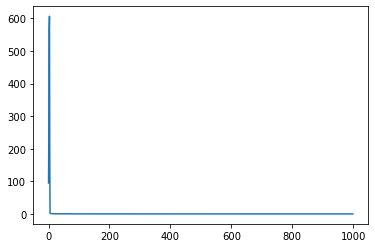

In [11]:
plt.plot(torch.arange(losses.size(0)), losses.detach().numpy());

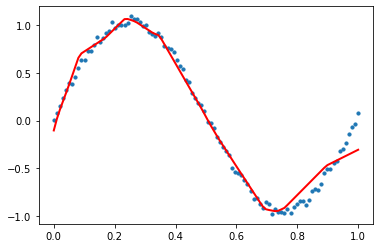

In [12]:
_, ax = plt.subplots(1)

ax.scatter(X, y, s=10)
ax.plot(X, predicts.detach(), color='r', lw=2);

## 2. Алгоритмы оптимизации в `torch.optim`

In [13]:
import torch.optim as optim

2.1 Решить задачу 1.1, воспользовавшись оптимизатором `optim.SDG` для применения стохастического градиентого спуска

In [14]:
X, y, coef = make_regression(n_features=4, n_informative=4, coef=True, bias=0.5)
X = torch.from_numpy(X).to(dtype=torch.float32)
y = torch.from_numpy(y).to(dtype=torch.float32)

In [15]:
torch.manual_seed(0)

neuron = Neuron(X.size(1))
mse_l = MSE_Loss()

lr = 0.1
optimizer = optim.SGD([neuron.weights, neuron.bias], lr=lr)

epochs = 10
for epoch in range(epochs):
    for i, (x, y_true) in enumerate(zip(X, y)):
        optimizer.zero_grad()

        y_pred = neuron.forward(x)
        loss = mse_l.forward(y_pred, y_true)
        loss.backward()

        optimizer.step()

neuron.weights, coef

(tensor([61.8860,  0.2905, 73.4126, 77.4154], requires_grad=True),
 array([61.88595909,  0.29044994, 73.41256623, 77.41538837]))

2.2 Решить задачу 1.2, воспользовавшись оптимизатором `optim.Adam` для применения пакетного градиентого спуска. Вывести график функции потерь в зависимости от номера эпохи. Вывести на одном графике исходные данные и предсказанные значения.

In [16]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size())

In [17]:
torch.manual_seed(0)

fc1 = Linear(X.size(1), 100)
relu = ReLU()
fc2 = Linear(100, y.size(1))
mse = MSELoss()

lr = 0.01
optimizer = optim.Adam([fc1.weights, fc1.biases, fc2.weights, fc2.biases], lr=lr)

epochs = 1000

losses = torch.empty(epochs)

for epoch in range(1000):
    optimizer.zero_grad()

    y_pred = fc2.forward(relu.forward(fc1.forward(X)))
    loss = mse.forward(y_pred, y)
    loss.backward()
    losses[epoch] = loss

    optimizer.step()

predicts = fc2.forward(relu.forward(fc1.forward(X)))

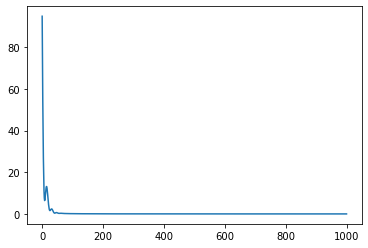

In [18]:
plt.plot(torch.arange(losses.size(0)), losses.detach().numpy());

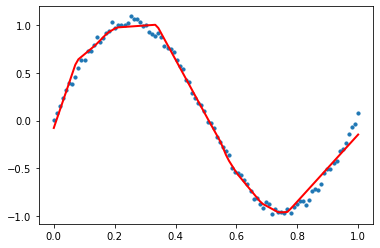

In [19]:
_, ax = plt.subplots(1)

ax.scatter(X, y, s=10)
ax.plot(X, predicts.detach(), color='r', lw=2);

## 3. Построение сетей при помощи `torch.nn`

In [20]:
import torch.nn as nn

3.1 Решить задачу регрессии, соблюдая следующие условия:

1. Оформить нейронную сеть в виде класса - наследника `nn.Module`
2. При создании сети использовать готовые блоки из `torch.nn`: слои, функции активации, функции потерь и т.д.
3. Для оптимизации использовать любой алгоритм оптимизации из `torch.optim` 

In [40]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size()) 

In [41]:
class NHeir(nn.Module):

    def __init__(self, n_features: int, n_neurons: int):
        super(NHeir, self).__init__()
        self.n_features = n_features
        self.n_neurons = n_neurons

        self.fc1 = nn.Linear(self.n_features, 100)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(100, self.n_neurons)

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        return self.fc2(self.relu(self.fc1(inputs)))

In [42]:
torch.manual_seed(0)

nh = NHeir(X.size(1), y.size(1))
optimize = optim.Adam(nh.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [43]:
for epoch in range(800):
    optimize.zero_grad()

    y_pred = nh(X)
    loss = criterion(y_pred, y)
    loss.backward()

    optimize.step()

predicts = nh(X)

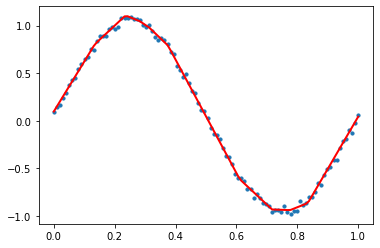

In [44]:
_, ax = plt.subplots(1)

ax.scatter(X, y, s=10)
ax.plot(X, predicts.detach(), color='r', lw=2);

3.2 Решить задачу регрессии, соблюдая следующие условия:

1. Оформить нейронную сеть в виде объекта `nn.Sequential`
2. При создании сети использовать готовые блоки из `torch.nn`: слои, функции активации, функции потерь и т.д.
3. Для оптимизации использовать любой алгоритм оптимизации из `torch.optim` 

In [87]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size()) 

In [88]:
torch.manual_seed(0)

In [89]:
n_features = X.size(1)
n_neurons = y.size(1)

In [90]:
nh = nn.Sequential(
    nn.Linear(n_features, 30),
    nn.ReLU(),
    nn.Linear(30, 100),
    nn.ReLU(),
    nn.Linear(100, n_neurons),
)
criterion = nn.L1Loss()
optimize = optim.Adagrad(nh.parameters(), lr=0.05)

In [91]:
for epoch in range(1500):
    optimize.zero_grad()

    y_pred = nh(X)
    loss = criterion(y_pred, y)
    loss.backward()

    optimize.step()

predicts = nh(X)

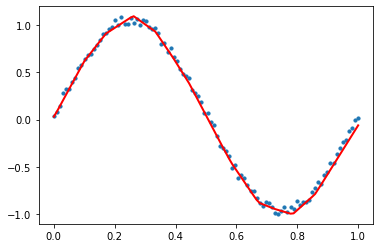

In [92]:
_, ax = plt.subplots(1)

ax.scatter(X, y, s=10)
ax.plot(X, predicts.detach(), color='r', lw=2);

3.3 Решить задачу классификации. Датасет: Breast Cancer Wisconsin
1. Оформить нейронную сеть в виде объекта `nn.Sequential`
2. При создании сети использовать готовые блоки из `torch.nn`: слои, функции активации, функции потерь и т.д.
3. Для оптимизации использовать любой алгоритм оптимизации из `torch.optim` 

In [106]:
from sklearn import datasets, metrics

data = datasets.load_breast_cancer()
X = torch.from_numpy(data.data).to(torch.float32)
y = torch.from_numpy(data.target).to(torch.float32).view(-1, 1)

In [107]:
torch.manual_seed(0)

In [108]:
nh = nn.Sequential(
    nn.Linear(X.size(1), 50),
    nn.ReLU(),
    nn.Linear(50, y.size(1)),
    nn.Sigmoid(),
)

optimize = optim.SGD(nh.parameters(), lr=0.01, momentum=0.9)
criterion = nn.BCELoss()

In [109]:
epochs = 800
for epoch in range(epochs + 1):
    optimize.zero_grad()

    y_pred = nh(X)
    loss = criterion(y_pred, y)
    loss.backward()

    optimize.step()

    if epoch % 100 == 0:
        acc = metrics.accuracy_score(y, y_pred.round().detach().numpy())
        print(f"Epoch №{epoch} -> loss = {loss}, accuracy = {acc}")

Epoch №0 -> loss = 10.102731704711914, accuracy = 0.37258347978910367
Epoch №100 -> loss = 37.25834655761719, accuracy = 0.6274165202108963
Epoch №200 -> loss = 37.25834655761719, accuracy = 0.6274165202108963
Epoch №300 -> loss = 37.25834655761719, accuracy = 0.6274165202108963
Epoch №400 -> loss = 37.25834655761719, accuracy = 0.6274165202108963
Epoch №500 -> loss = 37.25834655761719, accuracy = 0.6274165202108963
Epoch №600 -> loss = 37.25834655761719, accuracy = 0.6274165202108963
Epoch №700 -> loss = 37.25834655761719, accuracy = 0.6274165202108963
Epoch №800 -> loss = 37.25834655761719, accuracy = 0.6274165202108963


In [110]:
torch.manual_seed(0)

In [111]:
#хочу попробовать с другой оптимизацией
data = datasets.load_breast_cancer()
X = torch.from_numpy(data.data).to(torch.float32)
y = torch.from_numpy(data.target).to(torch.float32).view(-1, 1)
nh = nn.Sequential(
    nn.Linear(X.size(1), 50),
    nn.ReLU(),
    nn.Linear(50, y.size(1)),
    nn.Sigmoid(),
)
criterion = nn.BCELoss()

In [112]:
optimize_2 = optim.Adam(nh.parameters(), lr=0.005)

In [113]:
epochs = 800
for epoch in range(epochs + 1):
    optimize_2.zero_grad()

    y_pred = nh(X)
    loss = criterion(y_pred, y)
    loss.backward()

    optimize_2.step()

    if epoch % 100 == 0:
        acc = metrics.accuracy_score(y, y_pred.round().detach().numpy())
        print(f"Epoch №{epoch} -> loss = {loss}, accuracy = {acc}")

Epoch №0 -> loss = 10.102731704711914, accuracy = 0.37258347978910367
Epoch №100 -> loss = 0.20632903277873993, accuracy = 0.9191564147627417
Epoch №200 -> loss = 0.17000000178813934, accuracy = 0.929701230228471
Epoch №300 -> loss = 0.14355461299419403, accuracy = 0.945518453427065
Epoch №400 -> loss = 0.12416836619377136, accuracy = 0.9507908611599297
Epoch №500 -> loss = 0.10899636894464493, accuracy = 0.9578207381370826
Epoch №600 -> loss = 0.09693359583616257, accuracy = 0.9578207381370826
Epoch №700 -> loss = 0.08754619210958481, accuracy = 0.961335676625659
Epoch №800 -> loss = 0.08034734427928925, accuracy = 0.961335676625659


## 4. Datasets and dataloaders

In [114]:
from torch.utils.data import Dataset, DataLoader, random_split, Subset

4.1 Создать датасет, поставляющий данные из задачи 1.2. 

Создать `DataLoader` на основе этого датасета и проверить работоспособность.

Воспользовавшись результатами 3.1 (или 3.2) обучите модель, пользуясь мини-пакетным градиентным спуском с размером пакета (`batch_size`) = 10

In [115]:
class SinDataset(Dataset):

    def __init__(self):
        self.data = torch.linspace(0, 1, 100).view(-1, 1)
        self.target = torch.sin(2 * np.pi * self.data) + 0.1 * torch.rand(self.data.size())

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return self.data[idx], self.target[idx]

In [116]:
sinDataset = SinDataset()
dataloader = DataLoader(sinDataset, batch_size=10)

X = sinDataset.data
y = sinDataset.target

In [117]:
nh = nn.Sequential(
    nn.Linear(X.size(1), 30),
    nn.ReLU(),
    nn.Linear(30, 100),
    nn.ReLU(),
    nn.Linear(100, y.size(1)),
)
criterion = nn.MSELoss()
optimize = optim.Adam(nh.parameters(), lr=0.005)

In [118]:
steps = len(dataloader)
epochs = 800
for epoch in range(epochs + 1):
    for i, (x_, y_) in enumerate(dataloader):
        optimize.zero_grad()

        y_pred = nh(x_)
        loss = criterion(y_pred, y_)
        loss.backward()

        optimize.step()

        if epoch % 100 == 0 and i % 5 == 0:
            print(f"Epoch № {epoch}, step № {i}]"
                  f" loss = {loss}, batch_size = {x_.size(0)}")

Epoch № 0, step № 0] loss = 0.16218958795070648, batch_size = 10
Epoch № 0, step № 5] loss = 0.6840108036994934, batch_size = 10
Epoch № 100, step № 0] loss = 0.020698469132184982, batch_size = 10
Epoch № 100, step № 5] loss = 0.17505747079849243, batch_size = 10
Epoch № 200, step № 0] loss = 0.011225285939872265, batch_size = 10
Epoch № 200, step № 5] loss = 0.01657615229487419, batch_size = 10
Epoch № 300, step № 0] loss = 0.011090116575360298, batch_size = 10
Epoch № 300, step № 5] loss = 0.012961896136403084, batch_size = 10
Epoch № 400, step № 0] loss = 0.01328627485781908, batch_size = 10
Epoch № 400, step № 5] loss = 0.012617702595889568, batch_size = 10
Epoch № 500, step № 0] loss = 0.012603839859366417, batch_size = 10
Epoch № 500, step № 5] loss = 0.00950542464852333, batch_size = 10
Epoch № 600, step № 0] loss = 0.010833422653377056, batch_size = 10
Epoch № 600, step № 5] loss = 0.008811882697045803, batch_size = 10
Epoch № 700, step № 0] loss = 0.0062590716406702995, batch_

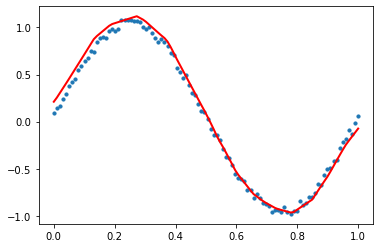

In [119]:
predicts = nh(X)

_, ax = plt.subplots(1)
ax.scatter(X, y, s=10)
ax.plot(X, predicts.detach(), color='r', lw=2);

4.2 Предсказание цен алмазов

4.2.1 Создайте датасет на основе файла diamonds.csv. 

1. Удалите все нечисловые столбцы
2. Целевой столбец (`y`) - `price`
3. Преобразуйте данные в тензоры корректных размеров

In [120]:
import pandas as pd
import seaborn as sns

In [130]:
class DiamondsDataset(Dataset):
    def __init__(self, data: pd.DataFrame):
        data = data.select_dtypes(np.number)
        features = data[data.columns.drop("price")]
        labels = data[["price"]]

        self.features = torch.from_numpy(features.to_numpy(dtype=np.float32))
        self.labels = torch.from_numpy(labels.to_numpy(dtype=np.float32))

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [131]:
diamonds = sns.load_dataset("diamonds", data_home="data/")
diamonds.head(2)

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31


In [132]:
dataset = DiamondsDataset(diamonds)
dataset.features.size(), dataset.labels.size()

(torch.Size([53940, 6]), torch.Size([53940, 1]))

4.2.2 Разбейте датасет на обучающий и тестовый датасет при помощи `torch.utils.data.random_split`.

In [133]:
size = round(0.8 * len(dataset))
train_dataset, test_dataset = random_split(dataset, lengths=(size, len(dataset) - size))

4.2.3 Обучите модель для предсказания цен при помощи мини-пакетного градиентного спуска (`batch_size = 256`). 

In [134]:
n = nn.Sequential(
    nn.Linear(dataset.features.size(1), 32),
    nn.Dropout(0.25),
    nn.ReLU(),
    nn.Linear(32, 96),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.Linear(96, 32),
    nn.Dropout(0.25),
    nn.ReLU(),
    nn.Linear(32, dataset.labels.size(1)),
    nn.ReLU(),
)

optimize = optim.Adam(n.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [135]:
n.train()
train_loader = DataLoader(train_dataset, batch_size=256)

steps = len(train_loader)
epochs = 50
losses = torch.empty(epochs + 1)

In [136]:
for epoch in range(epochs + 1):
    total_loss = 0
    for i, (x_, y_) in enumerate(train_loader):
        optimize.zero_grad()
        y_pred = n(x_)
        loss = criterion(y_pred, y_)
        loss.backward()
        optimize.step()

        total_loss += loss
        if epoch % 10 == 0 and i % 50 == 0:
            print(f"Epoch № {epoch}, step № {i}"
                  f" loss = {loss}, R2 = {metrics.r2_score(y_, y_pred.detach().numpy())}")

    losses[epoch] = total_loss / steps

Epoch № 0, step № 0 loss = 29779392.0, R2 = -0.9585733876919347
Epoch № 0, step № 50 loss = 33302816.0, R2 = -0.7585388244658997
Epoch № 0, step № 100 loss = 16725600.0, R2 = -0.04628186839727233
Epoch № 0, step № 150 loss = 18599836.0, R2 = -0.023743671520028764
Epoch № 10, step № 0 loss = 3073477.75, R2 = 0.7978591401861913
Epoch № 10, step № 50 loss = 4013773.75, R2 = 0.7880546294305567
Epoch № 10, step № 100 loss = 4434497.0, R2 = 0.72259684039111
Epoch № 10, step № 150 loss = 3672005.5, R2 = 0.7978910832734017
Epoch № 20, step № 0 loss = 2717868.75, R2 = 0.8212473497137817
Epoch № 20, step № 50 loss = 3594673.75, R2 = 0.8101850177340841
Epoch № 20, step № 100 loss = 4150153.0, R2 = 0.7403841937170346
Epoch № 20, step № 150 loss = 4679929.5, R2 = 0.742414504219194
Epoch № 30, step № 0 loss = 3079245.25, R2 = 0.7974798071002869
Epoch № 30, step № 50 loss = 3260934.5, R2 = 0.8278079566231115
Epoch № 30, step № 100 loss = 4253025.5, R2 = 0.7339489588513277
Epoch № 30, step № 150 loss 

4.2.4 Выведите график функции потерь в зависимости от номера эпохи (значение потерь для эпохи рассчитывайте как среднее значение ошибок на каждом батче). Проверьте качество модели на тестовой выборке. 

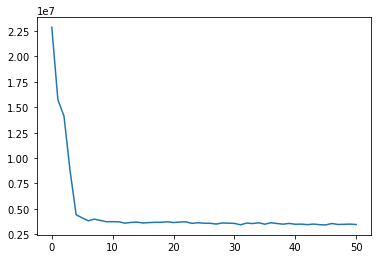

In [137]:
_ = plt.plot(torch.arange(losses.size(0)), losses.detach().numpy());

In [138]:
n.eval()

(X_train, y_train), (X_test, y_test) = train_dataset[:], test_dataset[:]
print(f"R2 train: {metrics.r2_score(y_train, n(X_train).detach().numpy())}")
print(f"R2 test: {metrics.r2_score(y_test, n(X_test).detach().numpy())}")

R2 train: 0.8644149134224091
R2 test: 0.8667677234338438


4.3 Модифицируйте метод `__init__` датасета из 4.2 таким образом, чтобы он мог принимать параметр `transform: callable`. Реализуйте класс `DropColsTransform` для удаления нечисловых данных из массива. Реализуйте класс `ToTensorTransorm` для трансформации массива в тензор.

In [139]:
class DiamondsDataset(Dataset):
    def __init__(self, data, transform):
        self.features = data[data.columns.drop("price")]
        self.labels = data[["price"]]
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sample = self.features[idx], self.labels[idx]
        
        if self.transform:
            return self.transform(sample)
        return sample

In [140]:
class DropColsTransform:
    def __init__(self, drop):
        self.drop = drop

    def __call__(self, sample):
        features, labels = sample
        return features.drop(columns=features.columns[self.drop]), labels

In [141]:
class ToTensorTransform:
    def __call__(self, sample):
        features, labels = sample
        features = torch.from_numpy(features.to_numpy(dtype=np.float32))
        labels = torch.from_numpy(labels.to_numpy(dtype=np.float32))
        return features, labels

In [142]:
from torchvision import transforms

In [143]:
transform = transforms.Compose([
    DropColsTransform(drop=[1, 2, 3]),
    ToTensorTransform(),
])

dataset = DiamondsDataset(diamonds, transform)

In [144]:
X, y = dataset[:]
X.size(), y.size()

(torch.Size([53940, 6]), torch.Size([53940, 1]))